In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Read in data ###

In [2]:
df = pd.read_csv('./datasets/basketball_data.csv') 

In [3]:
df.head()

,Season,GameId,GameDate,GameTime,HostName,GuestName,total_score,total_line,game_line,Host_HostRank,...,gPTS_avg10,gTS%_avg10,g3PAR_avg10,gFTr_avg10,gDRB%_avg10,gTRB%_avg10,gAST%_avg10,gSTL%_avg10,gBLK%_avg10,gDRtg_avg10
0,2013,201212090LAL,2012-12-09,6:30 pm,Los Angeles Lakers,Utah Jazz,227.0,207.5,7.5,13,...,99.0,0.5206,0.2230,0.2981,69.22,50.05,61.57,8.63,10.31,110.87
1,2013,201212100PHI,2012-12-10,7:00 pm,Philadelphia 76ers,Detroit Pistons,201.0,186.5,5.5,13,...,90.3,0.5077,0.2144,0.3095,71.46,49.48,59.83,6.48,9.46,107.91
2,2013,201212100HOU,2012-12-10,7:00 pm,Houston Rockets,San Antonio Spurs,240.0,212.0,-7.0,12,...,108.0,0.5915,0.2743,0.2518,74.26,50.99,61.82,8.30,6.85,101.41
3,2013,201212110BRK,2012-12-11,7:00 pm,Brooklyn Nets,New York Knicks,197.0,195.5,-3.5,12,...,100.3,0.5473,0.3595,0.2544,74.23,47.88,52.07,9.31,7.64,109.24
4,2013,201212110DET,2012-12-11,7:30 pm,Detroit Pistons,Denver Nuggets,195.0,203.5,-4.5,11,...,101.1,0.5605,0.2173,0.3177,68.45,50.40,56.33,7.67,7.83,114.86


### Create a new column 'ishostwinner' as Y. 1 = host won the game, 0 = host lost the game

In [4]:
df['ishostwinner'] = np.where(df['winner'] == df['HostName'],1,0)
df['ishostwinner'].value_counts()

1    2239
0    1529
Name: ishostwinner, dtype: int64

In [5]:
df.head()

,Season,GameId,GameDate,GameTime,HostName,GuestName,total_score,total_line,game_line,Host_HostRank,...,gTS%_avg10,g3PAR_avg10,gFTr_avg10,gDRB%_avg10,gTRB%_avg10,gAST%_avg10,gSTL%_avg10,gBLK%_avg10,gDRtg_avg10,ishostwinner
0,2013,201212090LAL,2012-12-09,6:30 pm,Los Angeles Lakers,Utah Jazz,227.0,207.5,7.5,13,...,0.5206,0.2230,0.2981,69.22,50.05,61.57,8.63,10.31,110.87,0
1,2013,201212100PHI,2012-12-10,7:00 pm,Philadelphia 76ers,Detroit Pistons,201.0,186.5,5.5,13,...,0.5077,0.2144,0.3095,71.46,49.48,59.83,6.48,9.46,107.91,1
2,2013,201212100HOU,2012-12-10,7:00 pm,Houston Rockets,San Antonio Spurs,240.0,212.0,-7.0,12,...,0.5915,0.2743,0.2518,74.26,50.99,61.82,8.30,6.85,101.41,0
3,2013,201212110BRK,2012-12-11,7:00 pm,Brooklyn Nets,New York Knicks,197.0,195.5,-3.5,12,...,0.5473,0.3595,0.2544,74.23,47.88,52.07,9.31,7.64,109.24,0
4,2013,201212110DET,2012-12-11,7:30 pm,Detroit Pistons,Denver Nuggets,195.0,203.5,-4.5,11,...,0.5605,0.2173,0.3177,68.45,50.40,56.33,7.67,7.83,114.86,0


### For sake of simplicity in this example we are dropping all non-numeric columns

In [6]:
drop_cols = [k for k in df.columns if df.dtypes[k] == 'O']
df.drop(columns = drop_cols,inplace=True)

### Create X and y. Then train_test_split X and y

In [7]:
X = df.copy()
X = X.drop(columns=['ishostwinner','Season'])
y = df['ishostwinner']

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

### Scale X data since we are using a KNN classifier ###
### First we model without using GridSearch or HyperParameter pipelines ###

In [9]:
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train) 
X_test_scaled = std_scaler.fit_transform(X_test)

In [10]:
X_train_scaled

array([[-0.70580279, -0.57551591, -0.94951828, ..., -0.04655966,
        -0.82102005,  0.18404964],
       [ 0.6777531 ,  0.82956272, -0.57873793, ...,  1.37156587,
        -0.44639853,  1.2592102 ],
       [ 0.94382155, -0.47515315,  0.8302274 , ...,  1.12130842,
        -1.25705492, -0.85908485],
       ...,
       [ 0.30525729,  0.07684202,  0.60775919, ...,  0.78763183,
        -1.84048188, -2.30940781],
       [-0.01402484, -0.47515315,  1.12685168, ...,  0.01410881,
         1.72149319, -1.19764605],
       [-0.43973435,  0.67901858, -1.24614256, ...,  0.48428947,
        -0.64906263, -1.29143665]])

In [11]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_scaled,y_train)

KNeighborsClassifier(n_neighbors=7)

In [12]:
knn.score(X_train_scaled,y_train)
knn.score(X_test_scaled,y_test)

knn.score(X_train,y_train)
knn.score(X_test,y_test)

0.7364429275692075

0.6206896551724138

0.6731133864239667

0.6534040671971706

### Use GridSearchCV to search over specified parameters for the estimator (in this case KNNeighborsClassifier) ###

In [13]:
# Create a dictionary of parameters that will be used for GridSearch
knn_params = {'n_neighbors': np.arange(1, 51, 10),'metric': ['euclidean', 'manhattan']}

#Instantiate a GridSearch object using KNN as estimator, estimator parameters to be grid search, number of cross fold validations
knn_grid_search = GridSearchCV(KNeighborsClassifier(),knn_params,cv=5,verbose=1,scoring='accuracy')


In [14]:
knn_grid_search.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1, 11, 21, 31, 41])},
             scoring='accuracy', verbose=1)

In [15]:
# GridSearch attributes
knn_grid_search.best_estimator_
knn_grid_search.best_score_
knn_grid_search.best_params_

KNeighborsClassifier(metric='manhattan', n_neighbors=41)

0.650366568914956

{'metric': 'manhattan', 'n_neighbors': 41}

In [16]:
#Score (accuracy score) of the model on train and test data
knn_grid_search.score(X_test_scaled,y_test)
knn_grid_search.score(X_train_scaled,y_train)

#Generate Y predictions 
predict_class = knn_grid_search.predict(X_test_scaled)
np.count_nonzero(predict_class)

0.671971706454465

0.6803185437997725

792

### Create a pipeline to chain transformers and estimator. Can have only one estimator and must be specified last.

In [17]:
pipeline = Pipeline([('ss',StandardScaler()),
                     ('lreg',LogisticRegression(max_iter = 3000))
                      ])

In [18]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('lreg', LogisticRegression(max_iter=3000))])

In [19]:
pipeline.score(X_test,y_test)
pipeline.score(X_train,y_train)

0.6931918656056587

0.7034508911642018

In [20]:
pipeline.steps

[('ss', StandardScaler()), ('lreg', LogisticRegression(max_iter=3000))]

In [21]:
pipe_predict_class = pipeline.predict(X_test)
np.count_nonzero(predict_class)

792

### Pipeline with GridSearch ###

In [22]:
logreg_params = { 'ss__with_mean': [True,False],
                 'ss__with_std': [True,False] ,
                 'lreg__solver':['liblinear','lbfgs'],
                 'lreg__penalty':['l2']
                 }

logreg_gridsearch = GridSearchCV(pipeline,logreg_params,cv=5,verbose=1,scoring='accuracy')


In [23]:
logreg_gridsearch.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('lreg',
                                        LogisticRegression(max_iter=3000))]),
             param_grid={'lreg__penalty': ['l2'],
                         'lreg__solver': ['liblinear', 'lbfgs'],
                         'ss__with_mean': [True, False],
                         'ss__with_std': [True, False]},
             scoring='accuracy', verbose=1)

In [24]:
logreg_gridsearch.score(X_train,y_train)
logreg_gridsearch.score(X_test,y_test)

np.count_nonzero(logreg_gridsearch.predict(X_test))

0.7034508911642018

0.6940760389036251

757

In [25]:
logreg_gridsearch.best_estimator_
logreg_gridsearch.best_score_

Pipeline(steps=[('ss', StandardScaler(with_mean=False)),
                ('lreg', LogisticRegression(max_iter=3000))])

0.6845034788108791

In [26]:
cvresults_df = pd.DataFrame(logreg_gridsearch.cv_results_)

In [27]:
cvresults_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lreg__penalty,param_lreg__solver,param_ss__with_mean,param_ss__with_std,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.073377,0.008630,0.002506,0.000185,l2,liblinear,True,True,"{'lreg__penalty': 'l2', 'lreg__solver': 'libli...",0.657197,0.672348,0.669829,0.700190,0.711575,0.682228,0.020306,3
1,0.170949,0.015910,0.002307,0.000091,l2,liblinear,True,False,"{'lreg__penalty': 'l2', 'lreg__solver': 'libli...",0.664773,0.676136,0.669829,0.692600,0.702087,0.681085,0.014078,6
2,0.075729,0.002796,0.002210,0.000165,l2,liblinear,False,True,"{'lreg__penalty': 'l2', 'lreg__solver': 'libli...",0.657197,0.674242,0.669829,0.703985,0.715370,0.684125,0.021899,2
3,0.173155,0.009052,0.002585,0.000277,l2,liblinear,False,False,"{'lreg__penalty': 'l2', 'lreg__solver': 'libli...",0.659091,0.674242,0.671727,0.696395,0.705882,0.681467,0.017127,5
4,0.055844,0.003735,0.002452,0.000137,l2,lbfgs,True,True,"{'lreg__penalty': 'l2', 'lreg__solver': 'lbfgs...",0.657197,0.672348,0.669829,0.700190,0.711575,0.682228,0.020306,3
5,0.245689,0.020392,0.002224,0.000195,l2,lbfgs,True,False,"{'lreg__penalty': 'l2', 'lreg__solver': 'lbfgs...",0.664773,0.676136,0.669829,0.692600,0.702087,0.681085,0.014078,6
6,0.277894,0.028465,0.002168,0.000151,l2,lbfgs,False,True,"{'lreg__penalty': 'l2', 'lreg__solver': 'lbfgs...",0.659091,0.674242,0.669829,0.703985,0.715370,0.684503,0.021441,1
7,0.804867,0.030036,0.002240,0.000199,l2,lbfgs,False,False,"{'lreg__penalty': 'l2', 'lreg__solver': 'lbfgs...",0.659091,0.672348,0.666034,0.694497,0.709677,0.680330,0.018874,8


In [29]:
import chart_studio as cst
import plotly as py

import plotly.graph_objs as go

#import cufflinks as cf
# Use cufflinks offline, don't push plots to the cloud
#cf.go_offline()

# Import modules to work with data visualizations offline
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [93]:
text_list = list(
    zip(
        'Test score: ' + cvresults_df.mean_test_score.round(4).apply(str),
        'Fit time: ' + cvresults_df.mean_fit_time.round(4).apply(str),
        'Solver: ' + cvresults_df.param_lreg__solver
    )
)
text = ['<br>'.join(t) for t in text_list]
cvresults_df['text'] = text

['Test score: 0.6822<br>Fit time: 0.0867<br>Solver: liblinear',
 'Test score: 0.6811<br>Fit time: 0.1907<br>Solver: liblinear',
 'Test score: 0.6841<br>Fit time: 0.0871<br>Solver: liblinear',
 'Test score: 0.6815<br>Fit time: 0.1931<br>Solver: liblinear',
 'Test score: 0.6822<br>Fit time: 0.0673<br>Solver: lbfgs',
 'Test score: 0.6811<br>Fit time: 0.3191<br>Solver: lbfgs',
 'Test score: 0.6845<br>Fit time: 0.3855<br>Solver: lbfgs',
 'Test score: 0.6803<br>Fit time: 1.2191<br>Solver: lbfgs']

In [94]:
cvresults_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lreg__penalty,param_lreg__solver,param_ss__with_mean,param_ss__with_std,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,text
0,0.086750,0.011184,0.004217,0.002539,l2,liblinear,True,True,"{'lreg__penalty': 'l2', 'lreg__solver': 'libli...",0.657197,0.672348,0.669829,0.700190,0.711575,0.682228,0.020306,3,Test score: 0.6822<br>Fit time: 0.0867<br>Solv...
1,0.190675,0.011200,0.003479,0.002196,l2,liblinear,True,False,"{'lreg__penalty': 'l2', 'lreg__solver': 'libli...",0.664773,0.676136,0.669829,0.692600,0.702087,0.681085,0.014078,6,Test score: 0.6811<br>Fit time: 0.1907<br>Solv...
2,0.087132,0.005849,0.002862,0.001307,l2,liblinear,False,True,"{'lreg__penalty': 'l2', 'lreg__solver': 'libli...",0.657197,0.674242,0.669829,0.703985,0.715370,0.684125,0.021899,2,Test score: 0.6841<br>Fit time: 0.0871<br>Solv...
3,0.193056,0.016071,0.002455,0.000519,l2,liblinear,False,False,"{'lreg__penalty': 'l2', 'lreg__solver': 'libli...",0.659091,0.674242,0.671727,0.696395,0.705882,0.681467,0.017127,5,Test score: 0.6815<br>Fit time: 0.1931<br>Solv...
4,0.067334,0.004128,0.002204,0.000062,l2,lbfgs,True,True,"{'lreg__penalty': 'l2', 'lreg__solver': 'lbfgs...",0.657197,0.672348,0.669829,0.700190,0.711575,0.682228,0.020306,3,Test score: 0.6822<br>Fit time: 0.0673<br>Solv...
5,0.319112,0.023577,0.004251,0.004345,l2,lbfgs,True,False,"{'lreg__penalty': 'l2', 'lreg__solver': 'lbfgs...",0.664773,0.676136,0.669829,0.692600,0.702087,0.681085,0.014078,6,Test score: 0.6811<br>Fit time: 0.3191<br>Solv...
6,0.385474,0.033499,0.004574,0.004943,l2,lbfgs,False,True,"{'lreg__penalty': 'l2', 'lreg__solver': 'lbfgs...",0.659091,0.674242,0.669829,0.703985,0.715370,0.684503,0.021441,1,Test score: 0.6845<br>Fit time: 0.3855<br>Solv...
7,1.219145,0.065742,0.002389,0.000202,l2,lbfgs,False,False,"{'lreg__penalty': 'l2', 'lreg__solver': 'lbfgs...",0.659091,0.672348,0.666034,0.694497,0.709677,0.680330,0.018874,8,Test score: 0.6803<br>Fit time: 1.2191<br>Solv...


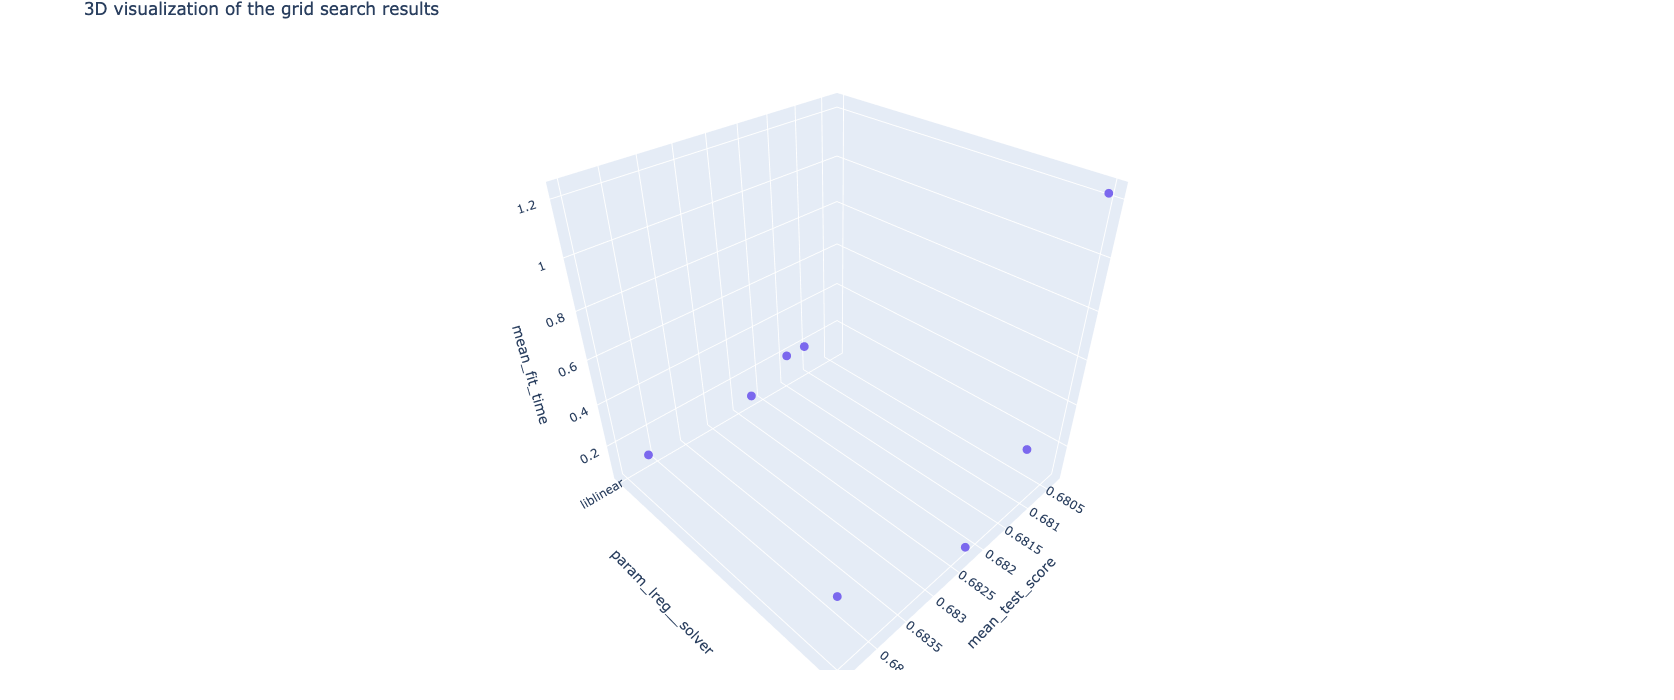

In [98]:
trace = go.Scatter3d(
    x=cvresults_df['mean_test_score'],
    y=cvresults_df['param_lreg__solver'],
    z=cvresults_df['mean_fit_time'],
    mode='markers', 
    marker=dict(
        size= 5,
        color='mediumslateblue',
        opacity=1.0
    ),
    text=cvresults_df.text,
    hoverinfo='text'
)

data = [trace]
layout = go.Layout(
    title='3D visualization of the grid search results',
    margin=dict(
        l=30,
        r=30,
        b=30,
        t=30
    ),
    height=700,
    width=960,
    scene = dict(
        xaxis = dict(
            title='mean_test_score',
            nticks=10
        ),
        yaxis = dict(
            title='param_lreg__solver',
            nticks = 10
        ),
        zaxis = dict(
            title='mean_fit_time',
            nticks = 10

        ),
    ),
 
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)